# Hail PCA Analysis

Author: Jonn Smith
Date: 2023 09 19

Notebook to perform PCA population clustering on joint-called results.
 
This takes advantage of the pre-created Hail Matrix Table outputs from `SRJointCallGVCFsWithGenomicsDB`.

NOTE: This notebook requires the following base image:

- `us.gcr.io/broad-dsp-gcr-public/terra-jupyter-hail:1.1.1`
 
***

## Initialize our imports and Hail

In [1]:
import hail as hl
hl.init()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bokeh.io import show
from bokeh.layouts import gridplot

# Make sure we show our data in our notebook:
# NOTE: This isn't working for some reason...
hl.plot.output_notebook()

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning: Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.
  warnings.warn(
SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/usr/lib/spark/jars/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://sa

Loading BokehJS ...

## Define some plotting functions to make our lives easier later

In [2]:
# Make big figures:
gFIG_SIZE_in = [14, 10]

# Set plotting defaults:
gPLOT_PARAMS = {
    "legend.fontsize": "x-large",
    "figure.figsize": gFIG_SIZE_in,
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large"
}
matplotlib.rcParams.update(gPLOT_PARAMS)
plt.rcParams.update(gPLOT_PARAMS)

# Some single-place definitions of sizes for plots / figures:
gFONT_SIZE_UNITS = "pt"
gTITLE_FONT_SIZE = 36
gAXIS_LABEL_FONT_SIZE = 24
gTICK_LABEL_FONT_SIZE = 16
gTEXT_FONT_SIZE = 16

# To track global figure number creation:
gFIG_NUM = 0


def fix_plot_visuals(fig,
                     titlesize=gTITLE_FONT_SIZE,
                     labelsize=gAXIS_LABEL_FONT_SIZE,
                     ticklabelsize=gTICK_LABEL_FONT_SIZE,
                     textsize=gTEXT_FONT_SIZE,
                     tight_rect=None):
    """Fix the plot elements to be appropriate sizes for a slide / presentation."""

    if not textsize:
        textsize = ticklabelsize

    for ax in fig.get_axes():

        for ticklabel in (ax.get_xticklabels()):
            ticklabel.set_fontsize(ticklabelsize)
        for ticklabel in (ax.get_yticklabels()):
            ticklabel.set_fontsize(ticklabelsize)
        for c in ax.get_children():
            if c.__class__ == matplotlib.text.Text:
                c.set_fontsize(textsize)

        ax.xaxis.get_label().set_fontsize(labelsize)
        ax.yaxis.get_label().set_fontsize(labelsize)
        ax.title.set_fontsize(titlesize)

    for c in fig.get_children():
        if c.__class__ == matplotlib.legend.Legend:
            c.prop.set_size(ticklabelsize)
            c.get_title().set_size(ticklabelsize)

    if tight_rect:
        fig.tight_layout(rect=tight_rect)
    else:
        fig.tight_layout()
    
    if fig._suptitle:
        sup_title = fig._suptitle.get_text()
        fig.suptitle(sup_title, fontsize=titlesize)
    
    # Make it so we can actually see what's happening on the plots with "dark mode":
    fig.patch.set_facecolor("white")

In [3]:
## Define some other settings:
# DIR_PREFIX="/home/jupyter/pca_analysis"
DIR_PREFIX = "gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/HAIL_intermediate_storage/pca_analysis"

## Load up our workspace info:

In [4]:
import os
import json

import firecloud.api as fapi
import pandas as pd
import numpy as np

from collections import defaultdict

import lrmaCU.terra.table_utils as lrma_table_utils

bucket = os.environ['WORKSPACE_BUCKET']
workspace = os.environ['WORKSPACE_NAME']
namespace = os.environ['WORKSPACE_NAMESPACE']

flowcell_table = "sample"
sample_table = "sample_set"
joint_call_table = "sample_set_set"

joint_call_set_column = "sample_sets"

In [5]:
print(f"Namespace: {namespace}")
print(f"Workspace: {workspace}")
print(f"Bucket:    {bucket}")
print()
print(f"Flowcell table: {flowcell_table}")
print(f"Sample table:   {sample_table}")
print(f"Joint call table:   {joint_call_table}")

Namespace: broad-firecloud-dsde-methods
Workspace: sr-malaria
Bucket:    gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd

Flowcell table: sample
Sample table:   sample_set
Joint call table:   sample_set_set


## Load the collection site info of each sample in this dataset:

In [6]:
# dataset_name = "Broad_2022_Senegal_Dataset_2"
# vcf_file = "gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/results/SRJointCallGVCFsWithGenomicsDB/Broad_2022_Senegal_Dataset_2/Broad_2022_Senegal_Dataset_2.rescored.combined.BETA_CALLSET.vcf.gz"

dataset_name = "Broad_2019_2022_Senegal_Dataset"
vcf_file = "gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/results/SRJointCallGVCFsWithGenomicsDB/Broad_2019_2022_Senegal_Dataset/Broad_2019_2022_Senegal_Dataset.rescored.combined.vcf.gz"

In [7]:
# Get the datasets:
joint_call_df = lrma_table_utils.fetch_existing_root_table(namespace, workspace, joint_call_table)

# Subset to the dataset we care about:
joint_call_data_set_df = joint_call_df[joint_call_df[joint_call_table] == dataset_name]

# Get sample IDs in our dataset:
sample_ids = set([i["entityName"] for i in list(joint_call_data_set_df[joint_call_set_column])[0]["items"]])

# Get the locations of the samples in our sample table:
sample_table_df = lrma_table_utils.fetch_existing_root_table(namespace, workspace, sample_table)

# Now get the samples / sites:
sample_site_df = sample_table_df[sample_table_df["sample_set"].isin(sample_ids)][["sample_set", "collection_site"]]

# Now convert them to a dict:
sample_site_dict = sample_site_df.set_index("sample_set")["collection_site"].to_dict()

# Let's make the inverse dict as well:
site_sample_dict = defaultdict(set)
for k,v in sample_site_dict.items():
    # Placeholder for now to fix datatable issue:
    # this is a check for nan values:
    if v != v:
        v = "Diourbel"
    site_sample_dict[v].add(k)

## Set up our reference

In [8]:
pf_ref = hl.ReferenceGenome.from_fasta_file(
    'Pf3D7',
    'gs://broad-dsde-methods-long-reads/resources/references/plasmodb_release-61/Pfalciparum3D7/fasta/data/PlasmoDB-61_Pfalciparum3D7_Genome.fasta',
    'gs://broad-dsde-methods-long-reads/resources/references/plasmodb_release-61/Pfalciparum3D7/fasta/data/PlasmoDB-61_Pfalciparum3D7_Genome.fasta.fai'
)

## Read in the joint-called VCF file:

In [9]:
mt = hl.import_vcf(
    vcf_file,
    array_elements_required=False,
    force_bgz=True,
    reference_genome=pf_ref
)

In [10]:
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<Pf3D7>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        CALIBRATION_SENSITIVITY: float64, 
        DB: bool, 
        DP: int32, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        HAPCOMP: array<int32>, 
        HAPDOM: array<float64>, 
        HEC: array<int32>, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQRankSum: float64, 
        NDA: int32, 
        QD: float64, 
        RAW_MQandDP: array<int32>, 
        ReadPosRankSum: float64, 
        SCORE: float64, 
        SOR: float64, 
        calibrat

In [11]:
hl.summarize_variants(mt)

2023-10-07 14:37:18.163 Hail: INFO: scanning VCF for sortedness...
2023-10-07 14:41:26.567 Hail: INFO: Coerced sorted VCF - no additional import work to do


Number of alleles,Count
2,2194439
3,1333068
4,489917
5,205846
6,102368
7,120260
Allele type,Count
SNP,3772274
Star,1708098
Insertion,1704707


## Run QC on our table so we can refer to it later
We need this for the filtration steps.

In [12]:
mt = hl.sample_qc(mt)
mt = hl.variant_qc(mt)

## Filter our variants
This will make it easier to compute the PCA as well as more informative for population-scale analyses.

### Prune low-frequency variants
Low frequency won't help us distinguish between populations.

In [13]:
min_minor_af = 0.01
common_mt = mt.filter_rows(mt.variant_qc.AF[1] > min_minor_af)

### Prune variants in Linkage Disequilibrium
This will make computing the PCA faster because we'll have removed variants that are not independent.

In [14]:
# Pulled directly from:
#.   the Hail tutoral at https://hail.is/docs/0.2/guides/genetics.html
#.   ls_prune docs at https://hail.is/docs/0.2/methods/genetics.html#hail.methods.ld_prune 
# 
# NOTE: we should probably tune the window size and r2 (squared correlation threshold) parameter.
biallelic_mt = common_mt.filter_rows(hl.len(common_mt.alleles) == 2)
pruned_variant_table = hl.ld_prune(biallelic_mt.GT, r2=0.2, bp_window_size=500000)
ld_pruned_mt = common_mt.filter_rows(hl.is_defined(pruned_variant_table[common_mt.row_key]))

2023-10-07 14:45:50.813 Hail: INFO: ld_prune: running local pruning stage with max queue size of 177069 variants
2023-10-07 15:18:15.690 Hail: INFO: wrote table with 98725 rows in 213 partitions to /tmp/persist_Table3Kl58S2TKT
2023-10-07 15:18:26.228 Hail: INFO: wrote table with 98725 rows in 213 partitions to /tmp/i1uriM56GJWpRgIDuJlXHu
2023-10-07 15:41:30.739 Hail: INFO: wrote matrix with 98725 rows and 1314 columns as 25 blocks of size 4096 to /tmp/cCsJk4QX6LkmLIoxaczvf3
2023-10-07 15:47:11.540 Hail: INFO: wrote table with 12586 rows in 49 partitions to /tmp/0mFmXPIXfEjYM9g2RlOH3D
2023-10-07 15:47:25.308 Hail: INFO: wrote table with 96623 rows in 213 partitions to /tmp/persist_TableSzGJ9xmVnU


In [15]:
hl.summarize_variants(ld_pruned_mt)

Number of alleles,Count
2,96623
Allele type,Count
SNP,86330
Insertion,7883
Deletion,2410
Metric,Value
Transitions,28902
Transversions,57428
Ratio,0.50
Contig,Count


In [16]:
# Write out the file so we can easily load it later:
mt.checkpoint(f"{DIR_PREFIX}/{dataset_name}.rescored.combined.BETA_CALLSET.mt", overwrite=True)

2023-10-07 16:53:33.007 Hail: INFO: wrote matrix table with 4445898 rows and 1314 columns in 213 partitions to gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/HAIL_intermediate_storage/pca_analysis/Broad_2019_2022_Senegal_Dataset.rescored.combined.BETA_CALLSET.mt


In [17]:
# Write out the file so we can easily load it later:
ld_pruned_mt.checkpoint(f"{DIR_PREFIX}/{dataset_name}.rescored.combined.BETA_CALLSET.ld_pruned", overwrite=True)

2023-10-07 17:42:34.527 Hail: INFO: wrote matrix table with 96623 rows and 1314 columns in 213 partitions to gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/HAIL_intermediate_storage/pca_analysis/Broad_2019_2022_Senegal_Dataset.rescored.combined.BETA_CALLSET.ld_pruned


## Identify polygenomic samples.
We need to filter polygenomic samples to make the PCA plot more clean.
We can do this by examining the barcode strings.

As per [Wong et al.](https://doi.org/10.1093%2Fpnasnexus%2Fpgac187), barcodes with 2 or more `N`s are considered polygenomic (in caption for [figure 2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9552330/figure/fig2/)).

In [26]:
# Apparently some barcodes are `nan` so the `b==b` check excludes them.
is_poly = np.array([b==b and b.count("N") > 2 for b in sample_table_df[sample_table_df["sample_set"].isin(sample_ids)].barcode])

monogenomic_samples = set(sample_table_df[sample_table_df["sample_set"].isin(sample_ids)]["sample_set"][~is_poly].values)
polygenomic_samples = set(sample_table_df[sample_table_df["sample_set"].isin(sample_ids)]["sample_set"][is_poly].values)

print(f"Number of polygenomic samples: {len(polygenomic_samples)}/{len(is_poly)}")
print(f"Number of monogenomic samples: {len(monogenomic_samples)}/{len(is_poly)}")

Number of polygenomic samples: 101/1315
Number of monogenomic samples: 1214/1315


### Shortcut: Use Steve Schaffner's lists for 2022 and 2019

In [27]:
sfs_2019_mono_unrelated = {"SEN-BAN-PP-DM1-2022-107", "SEN-BAN-PP-DM1-2022-126", "SEN-BAN-PP-DM1-2022-152", "SEN-BAN-PP-DM1-2022-156", "SEN-BAN-PP-DM1-2022-160", "SEN-BAN-PP-DM1-2022-161", "SEN-BAN-PP-DM1-2022-176", "SEN-BAN-PP-DM1-2022-186", "SEN-BAN-PP-DM2-2022-093", "SEN-BAN-PP-DM2-2022-099", "SEN-BAN-PP-DM2-2022-110", "SEN-BAN-PP-DM2-2022-123", "SEN-BAN-PP-DM2-2022-125", "SEN-BAN-PP-DM2-2022-130", "SEN-BAN-PP-DM2-2022-131", "SEN-BAN-PP-DM2-2022-132", "SEN-BAN-PP-DM2-2022-136", "SEN-BAN-PP-DM2-2022-139", "SEN-BAN-PP-DM2-2022-143", "SEN-BAN-PP-DM2-2022-150", "SEN-BAN-PP-DM3-2022-063", "SEN-BAN-PP-DM3-2022-071", "SEN-BAN-PP-DM3-2022-078", "SEN-BAN-PP-DM3-2022-086", "SEN-BAN-PP-DM3-2022-100", "SEN-BAN-PP-DM3-2022-132", "SEN-BAN-PP-DM3-2022-153", "SEN-BAN-PP-DM3-2022-155", "SEN-BAN-PP-DM3-2022-160", "SEN-BAN-PP-DM3-2022-169", "SEN-BAN-PP-DM3-2022-171", "SEN-BAN-PP-DM3-2022-175", "SEN-BAN-PP-PS-2022-192", "SEN-BAN-PP-PS-2022-198", "SEN-BAN-PP-PS-2022-201", "SEN-BAN-PP-PS-2022-204", "SEN-BAN-PP-PS-2022-238", "SEN-BAN-PP-PS-2022-252", "SEN-BAN-PP-PS-2022-264", "SEN-BAN-PP-PS-2022-265", "SEN-BAN-PP-PS-2022-269", "SEN-BAN-PP-PS-2022-270", "SEN-BAN-PP-PS-2022-272", "SEN-BAN-PP-PS-2022-278", "SEN-DBL-2022-001", "SEN-DBL-2022-006", "SEN-DBL-2022-007", "SEN-DBL-2022-008", "SEN-DBL-2022-009", "SEN-DBL-2022-012", "SEN-DBL-2022-013", "SEN-DBL-2022-017", "SEN-DBL-2022-021", "SEN-DBL-2022-025", "SEN-DBL-2022-030", "SEN-DBL-2022-032", "SEN-DBL-2022-034", "SEN-DBL-2022-036", "SEN-DBL-2022-039", "SEN-DBL-2022-040", "SEN-DBL-2022-043", "SEN-DBL-2022-044", "SEN-DBL-2022-049", "SEN-DBL-2022-050", "SEN-DBL-2022-052", "SEN-DBL-2022-056", "SEN-DBL-2022-057", "SEN-DBL-2022-059", "SEN-DBL-2022-061", "SEN-DBL-2022-062", "SEN-DBL-2022-065", "SEN-DBL-2022-066", "SEN-DBL-2022-071", "SEN-DBL-2022-074", "SEN-DBL-2022-075", "SEN-DBL-2022-082", "SEN-DBL-2022-087", "SEN-DBL-2022-089", "SEN-DBL-2022-090", "SEN-DBL-2022-091", "SEN-DBL-2022-092", "SEN-DBL-2022-093", "SEN-DBL-2022-100", "SEN-DBL-2022-106", "SEN-DBL-2022-107", "SEN-DBL-2022-108", "SEN-DBL-2022-109", "SEN-DBL-2022-125", "SEN-DBL-2022-129", "SEN-DBL-2022-131", "SEN-DBL-2022-137", "SEN-DBL-2022-147", "SEN-DBL-2022-148", "SEN-DBL-2022-150", "SEN-DBL-2022-151", "SEN-DBL-2022-157", "SEN-DBL-2022-158", "SEN-DBL-2022-159", "SEN-DBL-2022-164", "SEN-DBL-2022-168", "SEN-DBL-2022-171", "SEN-DBL-2022-173", "SEN-DBL-2022-174", "SEN-MAD-2022-124", "SEN-MAD-2022-127", "SEN-MAD-2022-177", "SEN-MAD-2022-180", "SEN-MAD-2022-181", "SEN-NDO-PP-PS-2022-221", "SEN-NDO-PP-PS-2022-233", "SEN-NDO-PP-PS-2022-245", "SEN-SES-PP-DM1-2022-091", "SEN-SES-PP-DM1-2022-122", "SEN-SES-PP-DM1-2022-124", "SEN-SLP-2022-001", "SEN-SLP-2022-002", "SEN-SLP-2022-004", "SEN-SLP-2022-005", "SEN-SLP-2022-010", "SEN-SLP-2022-012", "SEN-SLP-2022-014", "SEN-SLP-2022-015", "SEN-SLP-2022-016", "SEN-SLP-2022-017", "SEN-SLP-2022-018", "SEN-SLP-2022-020", "SEN-SLP-2022-022", "SEN-SLP-2022-023", "SEN-SLP-2022-024", "SEN-SLP-2022-025", "SEN-SLP-2022-026", "SEN-SLP-2022-027", "SEN-SLP-2022-028", "SEN-SLP-2022-031", "SEN-SLP-2022-032", "SEN-SLP-2022-033", "SEN-SLP-2022-034", "SEN-SLP-2022-035", "SEN-SLP-2022-036", "SEN-SLP-2022-037", "SEN-SLP-2022-039", "SEN-SLP-2022-040", "SEN-SLP-2022-041", "SEN-SLP-2022-042", "SEN-SLP-2022-043", "SEN-SLP-2022-044", "SEN-SLP-2022-047", "SEN-SLP-2022-048", "SEN-SLP-2022-049", "SEN-SLP-2022-051", "SEN-SLP-2022-052", "SEN-SLP-2022-053", "SEN-SLP-2022-054", "SEN-SLP-2022-055", "SEN-SLP-2022-056", "SEN-SLP-2022-057", "SEN-SLP-2022-059", "SEN-SLP-2022-061", "SEN-SLP-2022-062", "SEN-SLP-2022-063", "SEN-SLP-2022-064", "SEN-SLP-2022-068", "SEN-SLP-2022-069", "SEN-SLP-2022-070", "SEN-SLP-2022-073", "SEN-SLP-2022-075", "SEN-SLP-2022-076", "SEN-SLP-2022-077", "SEN-SLP-2022-078", "SEN-SLP-2022-080", "SEN-SLP-2022-083", "SEN-SLP-2022-084", "SEN-SLP-2022-085", "SEN-SLP-2022-086", "SEN-SLP-2022-090", "SEN-SLP-2022-091", "SEN-SLP-2022-092", "SEN-SLP-2022-093", "SEN-SLP-2022-099", "SEN-SLP-2022-100"}

sfs_2022_mono = {"SEN-BAN-PP-DM1-2022-107", "SEN-BAN-PP-DM1-2022-126", "SEN-BAN-PP-DM1-2022-152", "SEN-BAN-PP-DM1-2022-156", "SEN-BAN-PP-DM1-2022-160", "SEN-BAN-PP-DM1-2022-161", "SEN-BAN-PP-DM1-2022-176", "SEN-BAN-PP-DM1-2022-186", "SEN-BAN-PP-DM2-2022-093", "SEN-BAN-PP-DM2-2022-099", "SEN-BAN-PP-DM2-2022-110", "SEN-BAN-PP-DM2-2022-123", "SEN-BAN-PP-DM2-2022-125", "SEN-BAN-PP-DM2-2022-130", "SEN-BAN-PP-DM2-2022-131", "SEN-BAN-PP-DM2-2022-132", "SEN-BAN-PP-DM2-2022-136", "SEN-BAN-PP-DM2-2022-139", "SEN-BAN-PP-DM2-2022-143", "SEN-BAN-PP-DM2-2022-150", "SEN-BAN-PP-DM3-2022-063", "SEN-BAN-PP-DM3-2022-071", "SEN-BAN-PP-DM3-2022-078", "SEN-BAN-PP-DM3-2022-086", "SEN-BAN-PP-DM3-2022-100", "SEN-BAN-PP-DM3-2022-132", "SEN-BAN-PP-DM3-2022-153", "SEN-BAN-PP-DM3-2022-155", "SEN-BAN-PP-DM3-2022-160", "SEN-BAN-PP-DM3-2022-169", "SEN-BAN-PP-DM3-2022-171", "SEN-BAN-PP-DM3-2022-175", "SEN-BAN-PP-PS-2022-192", "SEN-BAN-PP-PS-2022-198", "SEN-BAN-PP-PS-2022-201", "SEN-BAN-PP-PS-2022-204", "SEN-BAN-PP-PS-2022-238", "SEN-BAN-PP-PS-2022-252", "SEN-BAN-PP-PS-2022-264", "SEN-BAN-PP-PS-2022-265", "SEN-BAN-PP-PS-2022-269", "SEN-BAN-PP-PS-2022-270", "SEN-BAN-PP-PS-2022-272", "SEN-BAN-PP-PS-2022-278", "SEN-DBL-2022-001", "SEN-DBL-2022-006", "SEN-DBL-2022-007", "SEN-DBL-2022-008", "SEN-DBL-2022-009", "SEN-DBL-2022-012", "SEN-DBL-2022-013", "SEN-DBL-2022-017", "SEN-DBL-2022-021", "SEN-DBL-2022-025", "SEN-DBL-2022-030", "SEN-DBL-2022-032", "SEN-DBL-2022-034", "SEN-DBL-2022-036", "SEN-DBL-2022-039", "SEN-DBL-2022-040", "SEN-DBL-2022-043", "SEN-DBL-2022-044", "SEN-DBL-2022-049", "SEN-DBL-2022-050", "SEN-DBL-2022-052", "SEN-DBL-2022-056", "SEN-DBL-2022-057", "SEN-DBL-2022-059", "SEN-DBL-2022-061", "SEN-DBL-2022-062", "SEN-DBL-2022-065", "SEN-DBL-2022-066", "SEN-DBL-2022-071", "SEN-DBL-2022-074", "SEN-DBL-2022-075", "SEN-DBL-2022-082", "SEN-DBL-2022-087", "SEN-DBL-2022-089", "SEN-DBL-2022-090", "SEN-DBL-2022-091", "SEN-DBL-2022-092", "SEN-DBL-2022-093", "SEN-DBL-2022-100", "SEN-DBL-2022-106", "SEN-DBL-2022-107", "SEN-DBL-2022-108", "SEN-DBL-2022-109", "SEN-DBL-2022-125", "SEN-DBL-2022-129", "SEN-DBL-2022-131", "SEN-DBL-2022-137", "SEN-DBL-2022-147", "SEN-DBL-2022-148", "SEN-DBL-2022-150", "SEN-DBL-2022-151", "SEN-DBL-2022-157", "SEN-DBL-2022-158", "SEN-DBL-2022-159", "SEN-DBL-2022-164", "SEN-DBL-2022-168", "SEN-DBL-2022-171", "SEN-DBL-2022-173", "SEN-DBL-2022-174", "SEN-MAD-2022-124", "SEN-MAD-2022-127", "SEN-MAD-2022-177", "SEN-MAD-2022-180", "SEN-MAD-2022-181", "SEN-NDO-PP-PS-2022-221", "SEN-NDO-PP-PS-2022-233", "SEN-NDO-PP-PS-2022-245", "SEN-SES-PP-DM1-2022-091", "SEN-SES-PP-DM1-2022-122", "SEN-SES-PP-DM1-2022-124", "SEN-SLP-2022-001", "SEN-SLP-2022-002", "SEN-SLP-2022-004", "SEN-SLP-2022-005", "SEN-SLP-2022-010", "SEN-SLP-2022-012", "SEN-SLP-2022-014", "SEN-SLP-2022-015", "SEN-SLP-2022-016", "SEN-SLP-2022-017", "SEN-SLP-2022-018", "SEN-SLP-2022-020", "SEN-SLP-2022-022", "SEN-SLP-2022-023", "SEN-SLP-2022-024", "SEN-SLP-2022-025", "SEN-SLP-2022-026", "SEN-SLP-2022-027", "SEN-SLP-2022-028", "SEN-SLP-2022-031", "SEN-SLP-2022-032", "SEN-SLP-2022-033", "SEN-SLP-2022-034", "SEN-SLP-2022-035", "SEN-SLP-2022-036", "SEN-SLP-2022-037", "SEN-SLP-2022-039", "SEN-SLP-2022-040", "SEN-SLP-2022-041", "SEN-SLP-2022-042", "SEN-SLP-2022-043", "SEN-SLP-2022-044", "SEN-SLP-2022-047", "SEN-SLP-2022-048", "SEN-SLP-2022-049", "SEN-SLP-2022-051", "SEN-SLP-2022-052", "SEN-SLP-2022-053", "SEN-SLP-2022-054", "SEN-SLP-2022-055", "SEN-SLP-2022-056", "SEN-SLP-2022-057", "SEN-SLP-2022-059", "SEN-SLP-2022-061", "SEN-SLP-2022-062", "SEN-SLP-2022-063", "SEN-SLP-2022-064", "SEN-SLP-2022-068", "SEN-SLP-2022-069", "SEN-SLP-2022-070", "SEN-SLP-2022-073", "SEN-SLP-2022-075", "SEN-SLP-2022-076", "SEN-SLP-2022-077", "SEN-SLP-2022-078", "SEN-SLP-2022-080", "SEN-SLP-2022-083", "SEN-SLP-2022-084", "SEN-SLP-2022-085", "SEN-SLP-2022-086", "SEN-SLP-2022-090", "SEN-SLP-2022-091", "SEN-SLP-2022-092", "SEN-SLP-2022-093", "SEN-SLP-2022-099", "SEN-SLP-2022-100"}
sfs_2022_clones = {"SEN-SLP-2022-033", "SEN-SLP-2022-014", "SEN-SLP-2022-073", "SEN-DBL-2022-034", "SEN-SLP-2022-100", "SEN-DBL-2022-001", "SEN-DBL-2022-158", "SEN-SLP-2022-020", "SEN-SLP-2022-052", "SEN-SLP-2022-041", "SEN-SLP-2022-070", "SEN-DBL-2022-009", "SEN-SLP-2022-068", "SEN-DBL-2022-157", "SEN-DBL-2022-159", "SEN-DBL-2022-061", "SEN-DBL-2022-056", "SEN-DBL-2022-129", "SEN-SLP-2022-031", "SEN-DBL-2022-174", "SEN-SLP-2022-025", "SEN-BAN-PP-PS-2022-278", "SEN-DBL-2022-168", "SEN-SLP-2022-004", "SEN-DBL-2022-007", "SEN-SLP-2022-056", "SEN-DBL-2022-062", "SEN-DBL-2022-150", "SEN-DBL-2022-108", "SEN-DBL-2022-087", "SEN-DBL-2022-125", "SEN-DBL-2022-107", "SEN-SLP-2022-059", "SEN-MAD-2022-181", "SEN-SLP-2022-054", "SEN-SLP-2022-084", "SEN-DBL-2022-148", "SEN-SLP-2022-076", "SEN-BAN-PP-DM1-2022-161", "SEN-DBL-2022-109", "SEN-DBL-2022-057", "SEN-SLP-2022-078", "SEN-DBL-2022-025", "SEN-DBL-2022-171", "SEN-DBL-2022-164", "SEN-SLP-2022-002", "SEN-BAN-PP-DM2-2022-139", "SEN-SLP-2022-047", "SEN-DBL-2022-039", "SEN-DBL-2022-044", "SEN-DBL-2022-008", "SEN-SLP-2022-083", "SEN-DBL-2022-092", "SEN-SLP-2022-032", "SEN-SLP-2022-093", "SEN-SLP-2022-069", "SEN-DBL-2022-071", "SEN-DBL-2022-131", "SEN-DBL-2022-100", "SEN-DBL-2022-082", "SEN-SLP-2022-063", "SEN-DBL-2022-066", "SEN-DBL-2022-036", "SEN-SLP-2022-028", "SEN-SLP-2022-053", "SEN-SLP-2022-057", "SEN-SLP-2022-064", "SEN-DBL-2022-052", "SEN-DBL-2022-106", "SEN-SLP-2022-080", "SEN-SLP-2022-099", "SEN-DBL-2022-017", "SEN-DBL-2022-043", "SEN-DBL-2022-032", "SEN-SLP-2022-026", "SEN-SLP-2022-037", "SEN-DBL-2022-012", "SEN-DBL-2022-090", "SEN-SLP-2022-085", "SEN-SLP-2022-077", "SEN-DBL-2022-065", "SEN-BAN-PP-DM1-2022-156", "SEN-DBL-2022-151", "SEN-SLP-2022-049", "SEN-SLP-2022-035", "SEN-SLP-2022-010", "SEN-SLP-2022-061", "SEN-DBL-2022-147", "SEN-SLP-2022-051", "SEN-SLP-2022-027", "SEN-DBL-2022-173", "SEN-DBL-2022-075", "SEN-DBL-2022-006", "SEN-DBL-2022-021", "SEN-SLP-2022-048", "SEN-SLP-2022-062", "SEN-SLP-2022-090"}
                           
sfs_2022_mono_unrelated = sfs_2022_mono - sfs_2022_clones

print(f"Num 2022 mono unrelated samples: {len(sfs_2022_mono_unrelated)}")
print(f"Num 2019 mono unrelated samples: {len(sfs_2019_mono_unrelated)}")

Num 2022 mono unrelated samples: 83
Num 2019 mono unrelated samples: 180


### Filter the `ld_pruned_mt` down to only the unrelated samples we care about:

In [30]:
# Collect samples to use for filtering:
# samples_to_keep = hl.literal(monogenomic_samples)
# samples_to_remove = hl.literal(related_samples_to_remove)

# samples_to_keep = hl.literal(sfs_2022_mono)
# samples_to_keep = hl.literal(sfs_2022_mono_unrelated)

samples_to_keep = hl.literal(sfs_2022_mono_unrelated.union(sfs_2019_mono_unrelated))

samples_to_remove = None

# Filter our samples:
ld_pruned_mono_unrelated_mt = ld_pruned_mt.filter_cols(samples_to_keep.contains(ld_pruned_mt['s']), keep=True)
if samples_to_remove:
    ld_pruned_mono_unrelated_mt = ld_pruned_mono_unrelated_mt.filter_cols(samples_to_remove.contains(ld_pruned_mono_unrelated_mt['s']), keep=False)

## Calculate the PCA between the samples and plot it:

In [31]:
ld_pruned_mt.GT.show()

,,,,,
,,'SEN-BAN-PP-DM1-2022-102','SEN-BAN-PP-DM1-2022-103','SEN-BAN-PP-DM1-2022-104','SEN-BAN-PP-DM1-2022-105'
locus,alleles,GT,GT,GT,GT
locus<Pf3D7>,array<str>,call,call,call,call
Pf3D7_01_v3:415,"[""G"",""C""]",0/0,0/0,0/0,0/0
Pf3D7_01_v3:543,"[""G"",""C""]",0/0,0/0,0/0,0/0
Pf3D7_01_v3:1069,"[""G"",""C""]",0/0,0/0,0/0,0/0
Pf3D7_01_v3:1095,"[""T"",""A""]",0/0,0/0,0/0,0/0
Pf3D7_01_v3:1142,"[""T"",""A""]",0/0,0/0,0/0,0/0
Pf3D7_01_v3:1171,"[""C"",""G""]",0/0,0/0,0/0,0/0
Pf3D7_01_v3:1196,"[""A"",""T""]",0/0,0/0,0/0,0/0


In [32]:
pca_eigenvalues, pca_scores, pca_loadings = hl.hwe_normalized_pca(ld_pruned_mt.GT, k=10, compute_loadings=True)

2023-10-07 21:46:18.442 Hail: INFO: hwe_normalize: found 96623 variants after filtering out monomorphic sites.
2023-10-07 21:57:58.186 Hail: INFO: pca: running PCA with 10 components.../ 213]
2023-10-07 22:23:07.811 Hail: INFO: Coerced sorted dataset>     (191 + 8) / 213]
2023-10-07 22:23:24.160 Hail: INFO: wrote table with 96623 rows in 213 partitions to /tmp/persist_TableDV27rq6mpt


In [33]:
# Plot PCA with bokeh / hail:
p = hl.plot.scatter(pca_scores.scores[0], pca_scores.scores[1],
                    title='PCA', xlabel='PC1', ylabel='PC2', collect_all=True)
show(p)

2023-10-07 22:23:25.034 Hail: INFO: Coerced sorted dataset


In [34]:
# Debugging code to test filtering:
# pca_eigenvalues, pca_scores, pca_loadings = hl.hwe_normalized_pca(ld_pruned_mono_unrelated_mt.GT, k=10, compute_loadings=True)

2023-10-07 22:23:26.699 Hail: INFO: Coerced sorted dataset
2023-10-07 22:23:27.678 Hail: INFO: Coerced sorted dataset


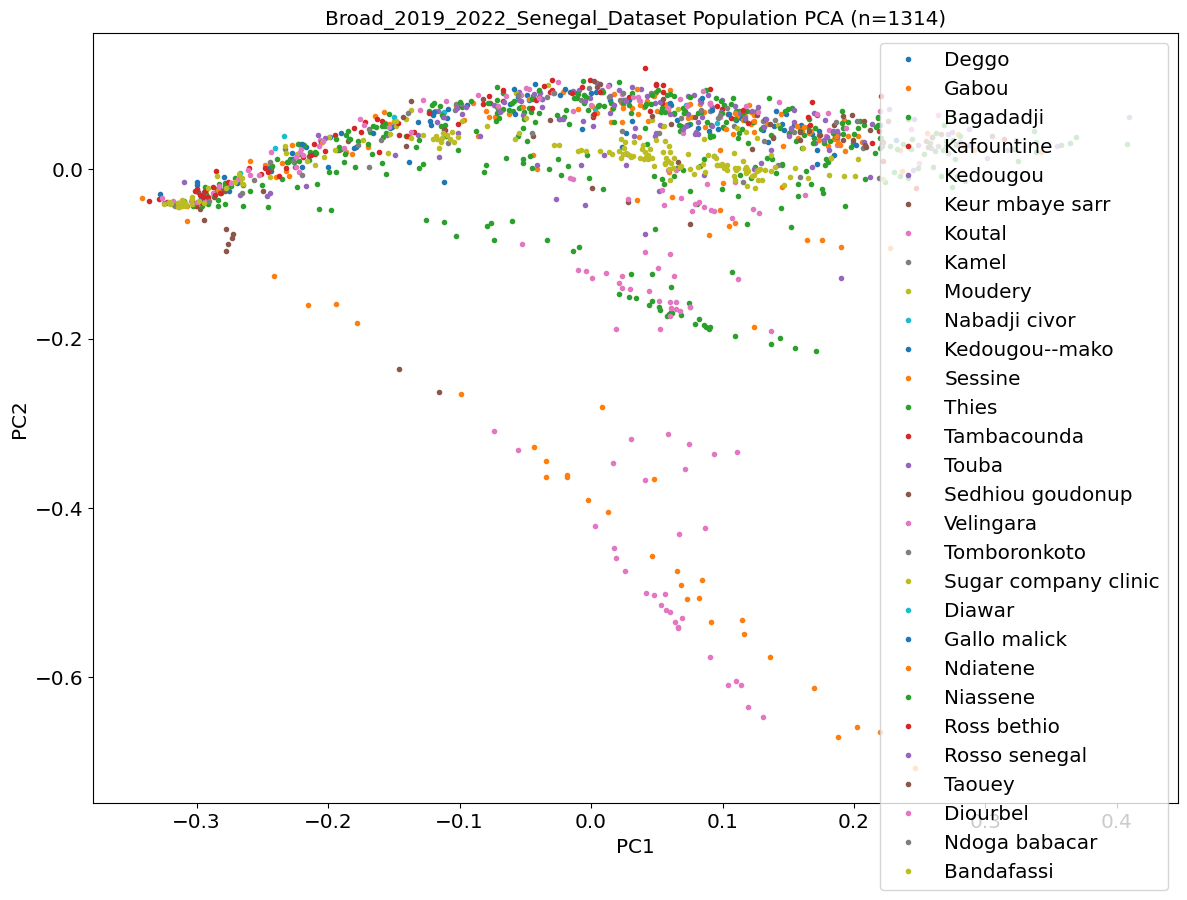

In [35]:
# Plot PCA with pyplot:
fig, ax = plt.subplots(1,1)

samples = pca_scores.s.collect()
pca_1 = np.array(pca_scores.scores[0].collect())
pca_2 = np.array(pca_scores.scores[1].collect())

# Iterate over the sites in our dict:
for site, samples_in_site in site_sample_dict.items():
    
    indices = [s in samples_in_site for s in samples]
    
    # We can rely on the built-in plot coloring for now:
    ax.plot(pca_1[indices], pca_2[indices], '.', label=site)

ax.set_title(f'{dataset_name} Population PCA (n={len(pca_1)})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

fig.show()

2023-10-07 22:23:31.009 Hail: INFO: Coerced sorted dataset
2023-10-07 22:23:31.909 Hail: INFO: Coerced sorted dataset


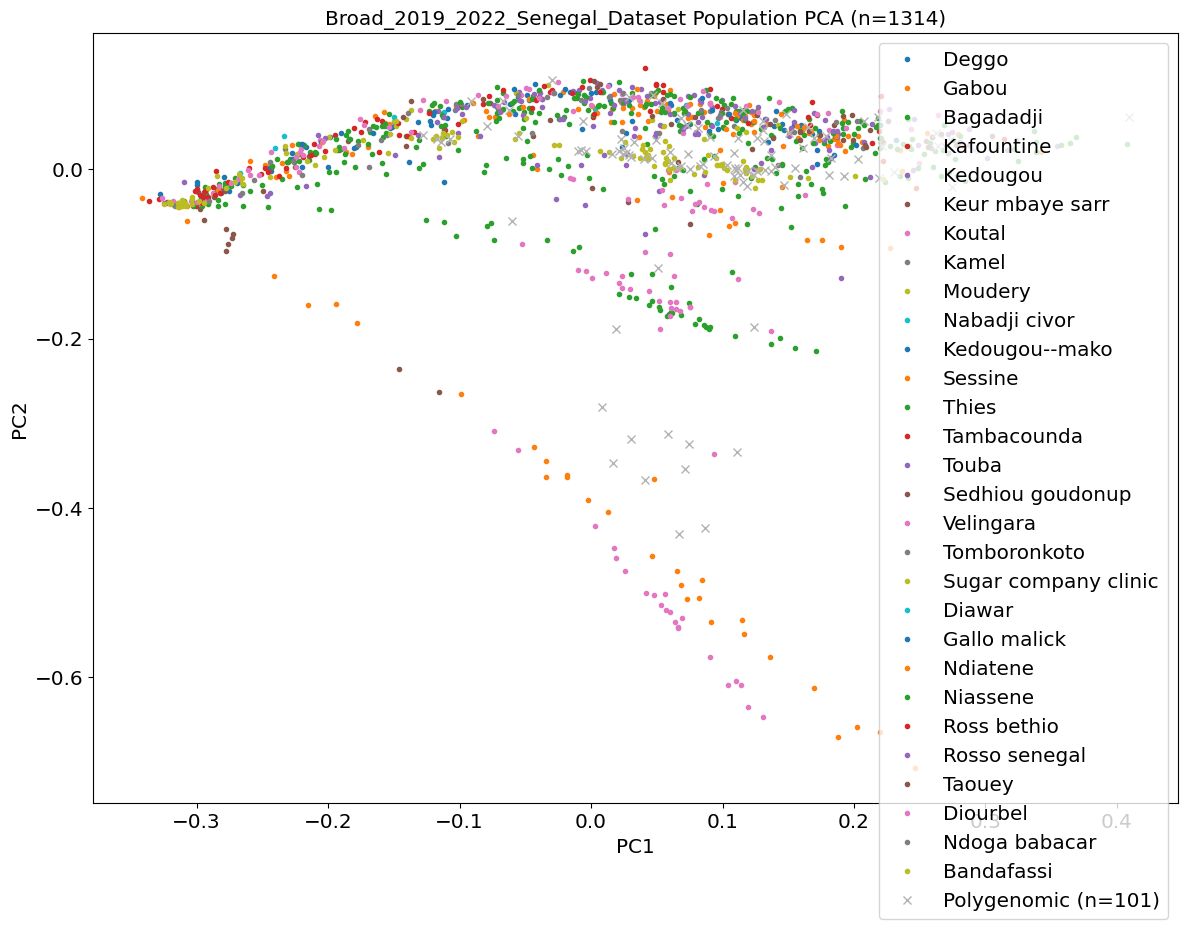

In [36]:
# Plot PCA with pyplot with polygenomic samples separated:
fig, ax = plt.subplots(1,1)

samples = pca_scores.s.collect()
pca_1 = np.array(pca_scores.scores[0].collect())
pca_2 = np.array(pca_scores.scores[1].collect())

# Iterate over the sites in our dict:
for site, samples_in_site in site_sample_dict.items():
    
    indices = [s in samples_in_site and s not in polygenomic_samples for s in samples]
    
    # We can rely on the built-in plot coloring for now:
    ax.plot(pca_1[indices], pca_2[indices], '.', label=site)

# Now plot our polygenomic samples:  
indices = [s in polygenomic_samples for s in samples]
ax.plot(pca_1[indices], pca_2[indices], 'x', label=f"Polygenomic (n={len(polygenomic_samples)})", color=[0.7]*3)

ax.set_title(f'{dataset_name} Population PCA (n={len(pca_1)})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

fig.show()

2023-10-07 22:23:33.844 Hail: INFO: Coerced sorted dataset
2023-10-07 22:23:34.816 Hail: INFO: Coerced sorted dataset
2023-10-07 22:23:35.694 Hail: INFO: Coerced sorted dataset


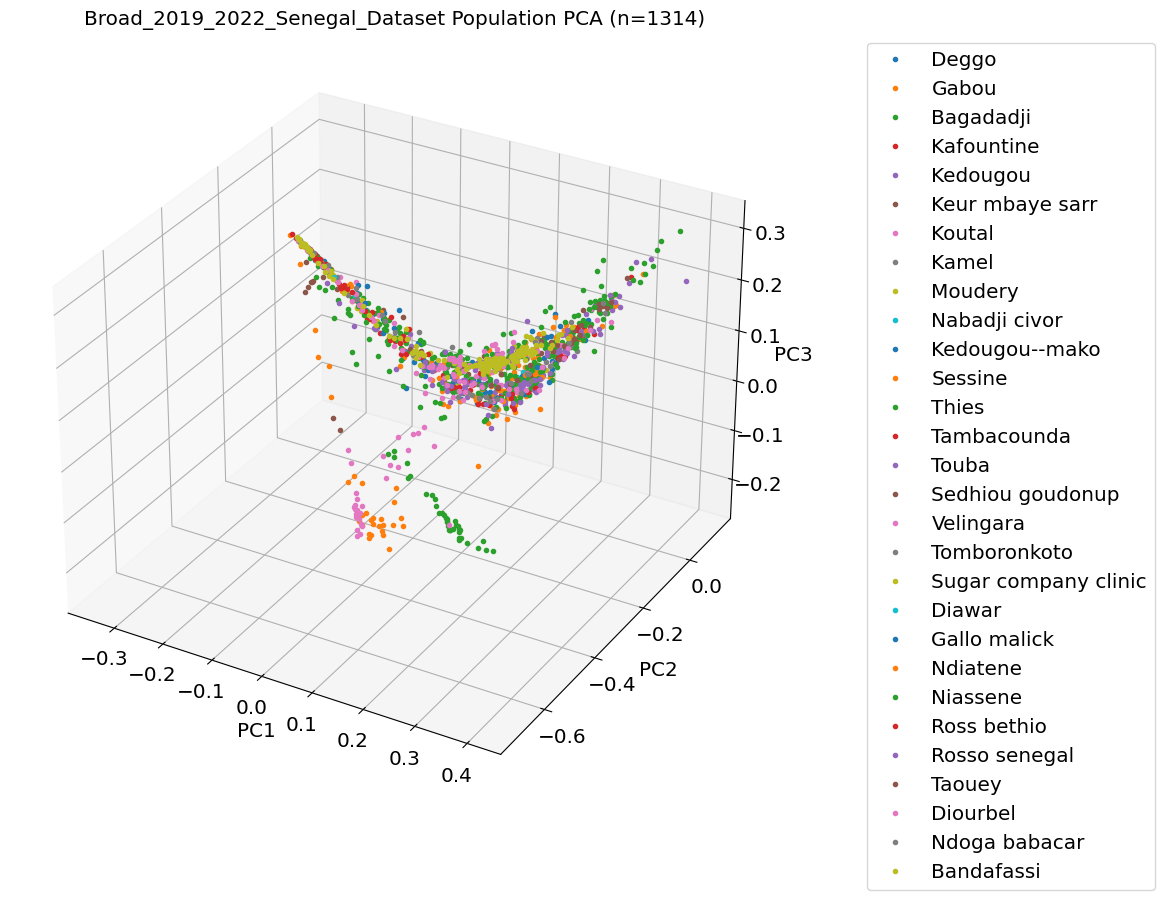

In [37]:
# Plot PCA with pyplot in 3D:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

samples = pca_scores.s.collect()
pca_1 = np.array(pca_scores.scores[0].collect())
pca_2 = np.array(pca_scores.scores[1].collect())
pca_3 = np.array(pca_scores.scores[3].collect())

# Iterate over the sites in our dict:
for site, samples_in_site in site_sample_dict.items():
    
    indices = [s in samples_in_site for s in samples]
    
    # We can rely on the built-in plot coloring for now:
    ax.plot3D(pca_1[indices], pca_2[indices], pca_3[indices], '.', label=site)

ax.set_title(f'{dataset_name} Population PCA (n={len(pca_1)})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(bbox_to_anchor=(1.5, 1))

fig.show()

2023-10-07 22:23:37.593 Hail: INFO: Coerced sorted dataset
2023-10-07 22:23:38.544 Hail: INFO: Coerced sorted dataset
2023-10-07 22:23:39.346 Hail: INFO: Coerced sorted dataset


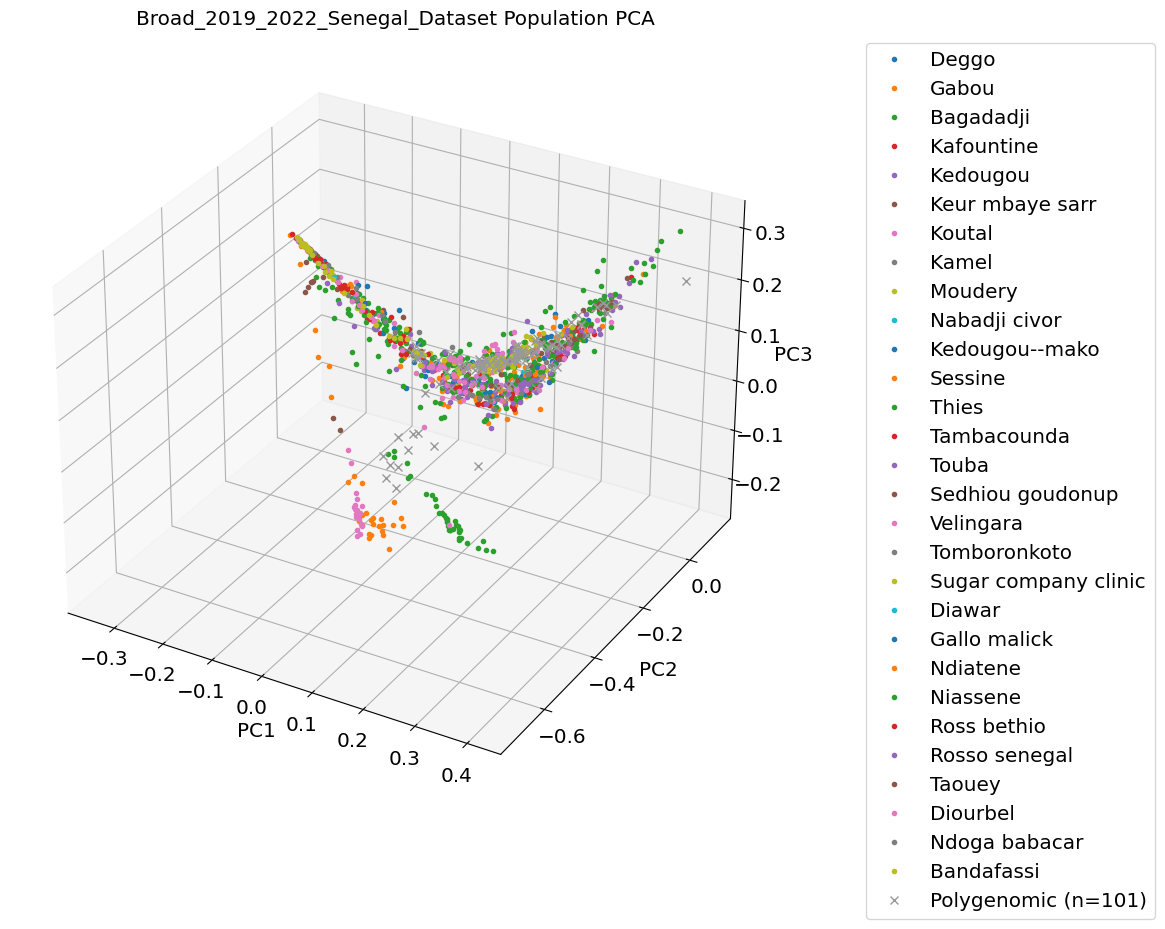

In [38]:
# Plot PCA with pyplot in 3D
# with polygenomic samples plotted in grey:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

samples = pca_scores.s.collect()
pca_1 = np.array(pca_scores.scores[0].collect())
pca_2 = np.array(pca_scores.scores[1].collect())
pca_3 = np.array(pca_scores.scores[3].collect())

# Iterate over the sites in our dict for monogenomic samples:
for site, samples_in_site in site_sample_dict.items():
    
    indices = [s in samples_in_site and s not in polygenomic_samples for s in samples]
    
    # We can rely on the built-in plot coloring for now:
    ax.plot3D(pca_1[indices], pca_2[indices], pca_3[indices], '.', label=site)

# Now plot our polygenomic samples:  
indices = [s in polygenomic_samples for s in samples]
ax.plot3D(pca_1[indices], pca_2[indices], pca_3[indices], 'x', label=f"Polygenomic (n={len(polygenomic_samples)})", color=[0.6]*3)

ax.set_title(f'{dataset_name} Population PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(bbox_to_anchor=(1.5, 1))

fig.show()

## Compute relatedness between samples using PCA (`pc_relate`)

In [39]:
rel = hl.pc_relate(ld_pruned_mt.GT,
                   0.01,
                   scores_expr=pca_scores[ld_pruned_mt.col_key].scores,
                   min_kinship=0) 

2023-10-07 23:09:15.227 Hail: INFO: wrote matrix with 96623 rows and 1314 columns as 24 blocks of size 4096 to /tmp/e1SX6gdvZc5kahZw0NXWe8
2023-10-07 23:09:18.924 Hail: INFO: wrote matrix with 11 rows and 96623 columns as 24 blocks of size 4096 to /tmp/pcrelate-write-read-0z0MSRtPDMkFhgFkdu6ufh.bm
2023-10-07 23:09:24.231 Hail: INFO: wrote matrix with 96623 rows and 1314 columns as 24 blocks of size 4096 to /tmp/pcrelate-write-read-WaiFaZfFvxinTqftNRDo94.bm
2023-10-07 23:09:42.810 Hail: INFO: wrote matrix with 96623 rows and 1314 columns as 24 blocks of size 4096 to /tmp/pcrelate-write-read-QRu7WFuqCGnMRA71a7jd2P.bm
2023-10-07 23:12:46.219 Hail: INFO: wrote matrix with 1314 rows and 1314 columns as 1 block of size 4096 to /tmp/pcrelate-write-read-Vlzht1x1ZOR5z5UfxqHzbB.bm
2023-10-07 23:15:38.945 Hail: INFO: wrote matrix with 1314 rows and 1314 columns as 1 block of size 4096 to /tmp/pcrelate-write-read-Otb55C1SfmD26Ir6Yam0EW.bm
2023-10-07 23:15:41.234 Hail: INFO: wrote matrix with 1314 

In [40]:
# Write out the eigenvalues, scores, and loadings to our storage location:
import pickle
fname=f"{dataset_name}.rescored.combined.BETA_CALLSET.ld_pruned.pca_eigenvalues.pkl"
with open(fname, 'wb') as f:
    pickle.dump(pca_eigenvalues, f)
!gsutil cp {fname} {DIR_PREFIX}/{fname}

pca_scores.checkpoint(f"{DIR_PREFIX}/{dataset_name}.rescored.combined.BETA_CALLSET.ld_pruned.pca_scores", overwrite=True)
pca_loadings.checkpoint(f"{DIR_PREFIX}/{dataset_name}.rescored.combined.BETA_CALLSET.ld_pruned.pca_loadings", overwrite=True)

Copying file://Broad_2019_2022_Senegal_Dataset.rescored.combined.BETA_CALLSET.ld_pruned.pca_eigenvalues.pkl [Content-Type=application/octet-stream]...
/ [1 files][  106.0 B/  106.0 B]                                                
Operation completed over 1 objects/106.0 B.                                      


2023-10-07 23:30:09.295 Hail: INFO: Coerced sorted dataset
2023-10-07 23:30:13.120 Hail: INFO: wrote table with 1314 rows in 16 partitions to gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/HAIL_intermediate_storage/pca_analysis/Broad_2019_2022_Senegal_Dataset.rescored.combined.BETA_CALLSET.ld_pruned.pca_scores
2023-10-07 23:31:02.515 Hail: INFO: wrote table with 96623 rows in 213 partitions to gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/HAIL_intermediate_storage/pca_analysis/Broad_2019_2022_Senegal_Dataset.rescored.combined.BETA_CALLSET.ld_pruned.pca_loadings


In [41]:
rel.checkpoint(f"{DIR_PREFIX}/{dataset_name}.rescored.combined.BETA_CALLSET.ld_pruned.pc_relate", overwrite=True)

2023-10-07 23:31:06.097 Hail: INFO: wrote table with 394153 rows in 1 partition to gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/HAIL_intermediate_storage/pca_analysis/Broad_2019_2022_Senegal_Dataset.rescored.combined.BETA_CALLSET.ld_pruned.pc_relate


In [42]:
# Show what the relatedness data look like:
rel.show()

,,,,,
i,j,,,,
s,s,kin,ibd0,ibd1,ibd2
str,str,float64,float64,float64,float64
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-103""",8.15e-03,1.08e+00,-1.85e-01,1.09e-01
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-105""",1.66e-02,1.02e+00,-1.04e-01,8.52e-02
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-107""",1.11e-02,9.46e-01,6.38e-02,-9.69e-03
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-114""",5.46e-03,9.53e-01,7.23e-02,-2.52e-02
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-116""",1.79e-03,1.02e+00,-5.08e-02,2.90e-02
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-118""",1.99e-02,1.03e+00,-1.38e-01,1.09e-01
"""SEN-BAN-PP-DM1-2022-102""","""SEN-BAN-PP-DM1-2022-120""",9.35e-03,9.67e-01,2.95e-02,3.96e-03


In [43]:
# Test some other filtering:
kinship_threshold = 0.05
pairs = rel.filter(rel['kin'] > kinship_threshold)
print(f"Num pairs > kinship threshold: {pairs.count()}/{rel.count()}")

s = set([s.s for s in pairs.i.collect()])
s.update([s.s for s in pairs.j.collect()])
print(f"Raw related samples to remove: {len(s)}")
print(f"Intersection with Steve's clones: {len(steves_clones.intersection(s))}/{len(steves_clones)}")

related_samples_to_remove_table = hl.maximal_independent_set(pairs.i, pairs.j, False)
related_samples_to_remove = set([s.node.s for s in related_samples_to_remove_table.collect()])
num_related = len(related_samples_to_remove)
num_in_dataset = ld_pruned_mt.count()[1]
print(f"Independent related samples detected: {num_related}/{num_in_dataset}")
print(f"Intersection with Steve's clones: {len(steves_clones.intersection(related_samples_to_remove))}/{len(steves_clones)}")

Num pairs > kinship threshold: 3251/394153
Raw related samples to remove: 723


NameError: name 'steves_clones' is not defined

## Remove related and polygenomic samples and rebuild PCA

In [ ]:
# related_samples_to_remove
# monogenomic_samples

***

In [ ]:
steves_clones = set(["SEN-SLP-2022-033", "SEN-SLP-2022-014", "SEN-SLP-2022-073", "SEN-DBL-2022-034", "SEN-SLP-2022-100", "SEN-DBL-2022-001", "SEN-DBL-2022-158", "SEN-SLP-2022-020", "SEN-SLP-2022-052", "SEN-SLP-2022-041", "SEN-SLP-2022-070", "SEN-DBL-2022-009", "SEN-SLP-2022-068", "SEN-DBL-2022-157", "SEN-DBL-2022-159", "SEN-DBL-2022-061", "SEN-DBL-2022-056", "SEN-DBL-2022-129", "SEN-SLP-2022-031", "SEN-DBL-2022-174", "SEN-SLP-2022-025", "SEN-BAN-PP-PS-2022-278", "SEN-DBL-2022-168", "SEN-SLP-2022-004", "SEN-DBL-2022-007", "SEN-SLP-2022-056", "SEN-DBL-2022-062", "SEN-DBL-2022-150", "SEN-DBL-2022-108", "SEN-DBL-2022-087", "SEN-DBL-2022-125", "SEN-DBL-2022-107", "SEN-SLP-2022-059", "SEN-MAD-2022-181", "SEN-SLP-2022-054", "SEN-SLP-2022-084", "SEN-DBL-2022-148", "SEN-SLP-2022-076", "SEN-BAN-PP-DM1-2022-161", "SEN-DBL-2022-109", "SEN-DBL-2022-057", "SEN-SLP-2022-078", "SEN-DBL-2022-025", "SEN-DBL-2022-171", "SEN-DBL-2022-164", "SEN-SLP-2022-002", "SEN-BAN-PP-DM2-2022-139", "SEN-SLP-2022-047", "SEN-DBL-2022-039", "SEN-DBL-2022-044", "SEN-DBL-2022-008", "SEN-SLP-2022-083", "SEN-DBL-2022-092", "SEN-SLP-2022-032", "SEN-SLP-2022-093", "SEN-SLP-2022-069", "SEN-DBL-2022-071", "SEN-DBL-2022-131", "SEN-DBL-2022-100", "SEN-DBL-2022-082", "SEN-SLP-2022-063", "SEN-DBL-2022-066", "SEN-DBL-2022-036", "SEN-SLP-2022-028", "SEN-SLP-2022-053", "SEN-SLP-2022-057", "SEN-SLP-2022-064", "SEN-DBL-2022-052", "SEN-DBL-2022-106", "SEN-SLP-2022-080", "SEN-SLP-2022-099", "SEN-DBL-2022-017", "SEN-DBL-2022-043", "SEN-DBL-2022-032", "SEN-SLP-2022-026", "SEN-SLP-2022-037", "SEN-DBL-2022-012", "SEN-DBL-2022-090", "SEN-SLP-2022-085", "SEN-SLP-2022-077", "SEN-DBL-2022-065", "SEN-BAN-PP-DM1-2022-156", "SEN-DBL-2022-151", "SEN-SLP-2022-049", "SEN-SLP-2022-035", "SEN-SLP-2022-010", "SEN-SLP-2022-061", "SEN-DBL-2022-147", "SEN-SLP-2022-051", "SEN-SLP-2022-027", "SEN-DBL-2022-173", "SEN-DBL-2022-075", "SEN-DBL-2022-006", "SEN-DBL-2022-021", "SEN-SLP-2022-048", "SEN-SLP-2022-062", "SEN-SLP-2022-090"])

In [ ]:
# Get a feeling for the 'kin' stat:
r = rel['kin'].collect()

In [ ]:
# Plot PCA with pyplot:
fig, ax = plt.subplots(1,1)

hist, bins = np.histogram(r, bins=500)

# We can rely on the built-in plot coloring for now:
ax.plot(bins[:-1] + ((bins[1]-bins[0])/2), hist, '.')

ax.set_title(f'{dataset_name} Population PCA Relatedness Kinship (n={len(pca_1)})')
ax.set_xlabel('kinship score')
ax.set_ylabel('count')

fig.show()

## Compute relatedness with `king`

In [ ]:
kinship = hl.king(ld_pruned_mt.GT)

In [ ]:
kinship.show()

In [ ]:
kinship.describe()

In [ ]:
kinship.aggregate_entries(hl.agg.stats(kinship.phi))

In [ ]:
kinship.filter_entries(kinship.phi > kinship_threshold, keep=False).show()

In [ ]:
hl.agg.any(kinship.phi > kinship_threshold)

In [ ]:
# Filter rows based on the threshold using annotate_rows
x = kinship.annotate_rows(
    entries_above_threshold = hl.agg.any(kinship.phi > kinship_threshold)
)

x.show()

x.describe()

# Collect the rows into a list
# filtered_rows = filtered_mt.rows().collect()

In [ ]:
kinship.entries_above_threshold

In [ ]:
help(kinship.annotate_rows)

## ~~Compute relatedness with PLINK's Identity By Descent (IBD) algorithm~~
NOTE: This algorithm isn't good for our malaria data because of the assumptions it makes about diploid alleles (thanks to Steve Schaffner for pointing this out).

In [ ]:
# Try Identity by Descent for relatedness to see if we get the same values:
#ibd = hl.identity_by_descent(hl.split_multi_hts(ld_pruned_mt))

In [ ]:
#ibd.checkpoint(f"{DIR_PREFIX}/Broad_2022_Senegal_Dataset_2.rescored.combined.BETA_CALLSET.ld_pruned.ibd", overwrite=True)

In [ ]:
# ibd.show()

In [ ]:
# ibd.order_by(hl.desc(ibd.ibd.PI_HAT)).show()

In [ ]:
# # Pi_hat is the kinship coefficient = (relationship coefficient)/2
# # More info: https://en.wikipedia.org/wiki/Coefficient_of_relationship#:~:text=Kinship%20coefficient,-The%20kinship%20coefficient&text=More%20simply%2C%20it%20is%20the,and%20from%20the%20same%20ancestor.
# # Seems like 0.1 is a good conservative threshold for relationship coeff.
# # therefore pi_hat_thresh = 0.05
# pi_hat_thresh = 0.05
# from collections import defaultdict
# ibd_related_rows = ibd.filter(ibd.ibd.PI_HAT >= pi_hat_thresh)
# print(f"Num sample pairs with IBD kinship coefficient >= {pi_hat_thresh} = {ibd_related_rows.count()}")

# all_samples_to_remove = set()
# ibd_sample_relation_dict = defaultdict(set)
# for i, j in zip(ibd_related_rows.i.collect(), ibd_related_rows.j.collect()):
#     ibd_sample_relation_dict[i].add(j)
#     all_samples_to_remove.add(i)
#     all_samples_to_remove.add(j)

## Create 3D rotating PCA plot

In [ ]:
raise RuntimeError("Stopping before rotating 3d PCA plot.  (canvas must be smaller)")

In [ ]:
# Now create rotating 3D plot:

# Adapted from:
#. https://stackoverflow.com/a/18345457
#. https://stackoverflow.com/a/43447370

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

samples = pca_scores.s.collect()
pca_1 = np.array(pca_scores.scores[0].collect())
pca_2 = np.array(pca_scores.scores[1].collect())
pca_3 = np.array(pca_scores.scores[3].collect())

# Iterate over the sites in our dict:
for site, samples_in_site in site_sample_dict.items():

    indices = [s in samples_in_site for s in samples]

    # We can rely on the built-in plot coloring for now:
    ax.plot3D(pca_1[indices], pca_2[indices], pca_3[indices], '.', label=site)

ax.set_title('Senegal 2022 Population PCA')

# TODO: Remove labels and tick labels.
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(1.5, 1))

def init():
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,


anim = animation.FuncAnimation(fig, animate, frames=360, interval=20, blit=True)

# # Save our data:
# NOTE
# anim.save("Senegal_2022_3d_pca.gif")

from IPython.display import HTML
HTML(anim.to_jshtml())

***
# Test loading Hail MT directly:
Why does this not work?

In [ ]:
mt_path = "gs://fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd/results/SRJointCallGVCFsWithGenomicsDB/Broad_2022_Senegal_Dataset_2/Broad_2022_Senegal_Dataset_2.mt"

new_mt = hl.read_matrix_table(mt_path)

***
# Scratch / Testing

In [52]:
import time
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket('fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd')


s = time.time()
top_level_dirs = dict()
for blob in bucket.list_blobs():
    name = blob.name[:blob.name.find("/")]
    if name not in top_level_dirs.keys():
        top_level_dirs[name] = blob

e = time.time()
print()
print(f"Elapsed time: {e-s}s")
print()
print("\n".join(sorted(list(top_level_dirs.keys()))))


Elapsed time: 117.1939070224762s

HAIL_intermediate_storage
backups
broad_gp_excel_files
inputs
manual_data_upload
notebooks
resources
results
results_new_test
scripts
submissions
tmp


In [53]:
import time
s = time.time()
for name, blob in top_level_dirs.items():
    print(f"{name}:\t{blob.size}")
        
e = time.time()
print()
print(f"Elapsed time: {e-s}s")

HAIL_intermediate_storage:	0
backups:	53286
broad_gp_excel_files:	0
inputs:	230460
manual_data_upload:	0
notebooks:	8297
resources:	1274
results:	45530
results_new_test:	0
scripts:	2571
submissions:	4403
tmp:	0

Elapsed time: 0.00023317337036132812s


In [54]:
storage_client = storage.Client()
bucket = storage_client.bucket('fc-b06e896e-cc1d-4deb-b638-f7b87c3e5dbd')

print("Getting all blob sizes...")
s = time.time()
blob_name_size = dict()
for blob in bucket.list_blobs():
    blob_name_size[blob.name] = blob.size

e = time.time()
print("Done.")
print()
print(f"Elapsed time: {e-s}s")
print()

Getting all blob sizes...
Done.

Elapsed time: 118.55600047111511s



In [64]:
# Get top-level dir sizes:

tld_sizes = defaultdict(int)
for name, size in blob_name_size.items():
    base_name = name[:name.find("/")]
    tld_sizes[base_name] += size

print("Top-level directory sizes:")
for name, size in tld_sizes.items():
    print(f"\t{name}:\t{size}\t{size/1024:2.0f}k\t{size/(1024**2):2.0f}m\t{size/(1024**3):2.0f}g\t{size/(1024**4):2.0f}t")

Top-level directory sizes:
	HAIL_intermediate_storage:	26599380616	25975958k	25367m	25g	 0t
	backups:	979189290	956240k	934m	 1g	 0t
	broad_gp_excel_files:	132331	129k	 0m	 0g	 0t
	inputs:	230559	225k	 0m	 0g	 0t
	manual_data_upload:	569311	556k	 1m	 0g	 0t
	notebooks:	9571556	9347k	 9m	 0g	 0t
	resources:	1274	 1k	 0m	 0g	 0t
	results:	123768208108619	120867390731k	118034561m	115268g	113t
	results_new_test:	0	 0k	 0m	 0g	 0t
	scripts:	2571	 3k	 0m	 0g	 0t
	submissions:	1060631	1036k	 1m	 0g	 0t
	tmp:	4981924	4865k	 5m	 0g	 0t


In [90]:
# Get sub-directory sizes:

def find_nth_occurrence(string, substring, n=1):
    start = 0
    index = -1
    while n > 0:
        i = string.find(substring, index+1)
        if i == -1:
            return -1
        index = i
        n -= 1

    return index


dir_start = "results"
sizes = defaultdict(int)
for name, size in blob_name_size.items():
    base_name = name[:name.find("/")]
    if base_name == dir_start:
        i = find_nth_occurrence(name, "/", 2)
        if i != -1:
            nn = name[:i]
            sizes[nn] += size

print("Top-level directory sizes:")
for name, size in sizes.items():
    print(f"\t{name}:\t{size}\t{size/1024:2.0f}k\t{size/(1024**2):2.0f}m\t{size/(1024**3):2.0f}g\t{size/(1024**4):2.0f}t")

Top-level directory sizes:
	results/ConvertToZarrStore:	119911896	117101k	114m	 0g	 0t
	results/JointCallGVCFs:	209108290	204207k	199m	 0g	 0t
	results/LRJointCallGVCFsWithGenomicsDB:	78913170884	77063643k	75257m	73g	 0t
	results/ONTPfTypeDrugResistanceMarkers:	15197209535	14841025k	14493m	14g	 0t
	results/PfalciparumDrugResistanceSummary:	66874	65k	 0m	 0g	 0t
	results/RemoveSingleOrganismContamination:	612717177	598357k	584m	 1g	 0t
	results/SRBamToFq:	103006328963	100592118k	98234m	96g	 0t
	results/SRFlowcell:	105433967092741	102962858489k	100549666m	98193g	96t
	results/SRJointCallGVCFsWithGenomicsDB:	471912008495	460851571k	450050m	440g	 0t
	results/SRWholeGenome:	17664270493764	17250264154k	16845961m	16451g	16t
